In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.2+cu121
0.16.2+cu121


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
    
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
set_seeds()

In [8]:
import os
import zipfile 

from pathlib import Path

import requests

def download_data(source: str,
                    destination: str,
                    remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination."""
    
    data_path = Path("data/")
    image_path = data_path /destination
    
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source) 
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
        
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)
            
        if remove_source:
            os.remove(data_path / target_file)

    return image_path
    
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                            destination="pizza_steak_sushi")
image_path    

[INFO] data\pizza_steak_sushi directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [9]:
train_dir = image_path / "train"
test_dir = image_path /"test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

from torchvision import transforms
manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize
])
print(f"Manually created transforms: {manual_transforms}")

from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=manual_transforms,
                                                                            batch_size=32)
train_dataloader, test_dataloader, class_names


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x21472416a40>,
 ['pizza', 'steak', 'sushi'])

In [13]:
train_dir = image_path / "train"
test_dir = image_path / "test"

import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=automatic_transforms,
                                                                            batch_size=32)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x21472961f00>,
 ['pizza', 'steak', 'sushi'])

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 


model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.features.parameters():
    # print(param)
    param.requires_grad = False


In [19]:
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)



In [20]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [34]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step


def train(model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"train_loss": train_loss,
                                    "test_loss": test_loss},
                            global_step=epoch)

        writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict={"train_acc": train_acc,
                                    "test_acc": test_acc},
                                global_step=epoch)

        writer.add_graph(model=model,
                    input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    writer.close()
    
    return results 

In [35]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828


 20%|██        | 1/5 [01:16<05:06, 76.54s/it]

Epoch: 2 | train_loss: 0.9204 | train_acc: 0.6445 | test_loss: 0.8134 | test_acc: 0.7746


 40%|████      | 2/5 [02:18<03:23, 67.82s/it]

Epoch: 3 | train_loss: 0.7602 | train_acc: 0.8750 | test_loss: 0.6562 | test_acc: 0.8864


 60%|██████    | 3/5 [03:39<02:27, 73.98s/it]

Epoch: 4 | train_loss: 0.6868 | train_acc: 0.7695 | test_loss: 0.6201 | test_acc: 0.8759


 80%|████████  | 4/5 [04:50<01:12, 72.71s/it]

Epoch: 5 | train_loss: 0.6467 | train_acc: 0.7969 | test_loss: 0.6054 | test_acc: 0.8665


100%|██████████| 5/5 [06:01<00:00, 72.34s/it]


In [36]:
results

{'train_loss': [1.0965989381074905,
  0.9203867614269257,
  0.7602226957678795,
  0.6868080906569958,
  0.6466987803578377],
 'train_acc': [0.38671875, 0.64453125, 0.875, 0.76953125, 0.796875],
 'test_loss': [0.8842612306276957,
  0.8134126861890157,
  0.6561941901842753,
  0.620058516661326,
  0.6053729057312012],
 'test_acc': [0.6827651515151515,
  0.774621212121212,
  0.8863636363636364,
  0.8759469696969697,
  0.8664772727272728]}

In [46]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8676), started 0:20:44 ago. (Use '!kill 8676' to kill it.)

In [44]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                    model_name: str,
                    extra: str = None):
    
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("$Y-%m-%d")
    
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [45]:
example_writer = create_writer(experiment_name="data_10_percent",
                                model_name="effnetb0",
                                extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs\$Y-02-22\data_10_percent\effnetb0\5_epochs


In [47]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device,
        writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
    For example if training for epochs=2: 
                {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """    
    
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        if writer:
            writer.add_scalars(main_tag="Loss",
                                tag_scalar_dict={"train_loss": train_loss,
                                        "test_loss": test_loss},
                                global_step=epoch)

            writer.add_scalars(main_tag="Accuracy",
                                tag_scalar_dict={"train_acc": train_acc,
                                        "test_acc": test_acc},
                                    global_step=epoch)

            writer.add_graph(model=model,
                        input_to_model=torch.randn(32, 3, 224, 224).to(device))
            
    writer.close()
    
    return results 

In [48]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory already exists, skipping download.
[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [49]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [50]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    normalize
])

In [51]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                test_dir=test_dir,
                                                                                transform=simple_transform,
                                                                                batch_size=BATCH_SIZE)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                test_dir=test_dir,
                                                                                transform=simple_transform,
                                                                                batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


In [52]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" = best available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\vilem/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:17<00:00, 2.13MB/s]


In [53]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [55]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = "effnetb0"
    print(f"[FNFO] Created new {model.name} model...")
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)
    
    model.name = "effnetb2"
    print(f"[FNFO] Created new {model.name} model...")
    return model

In [57]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[FNFO] Created new effnetb2 model...
[FNFO] Created new effnetb0 model...


In [58]:
summary(model=created_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [59]:
summary(model=created_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [67]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                        "data_20_percent": train_dataloader_20_percent}

In [68]:
%time
from going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device,
                    writer=create_writer(experiment_name=dataloader_name,
                                        model_name=model_name,
                                        extra=f"{epochs}_epochs"))
            
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                        target_dir="models",
                        model_name=save_filepath)
            print("-"*50 + "\n")

CPU times: total: 0 ns
Wall time: 0 ns
[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[FNFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs\$Y-02-22\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782


  0%|          | 0/5 [01:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs 

In [75]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')))

[FNFO] Created new effnetb2 model...


<All keys matched successfully>

In [76]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


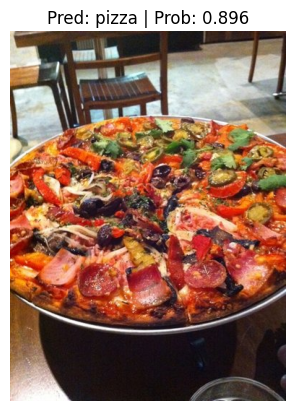

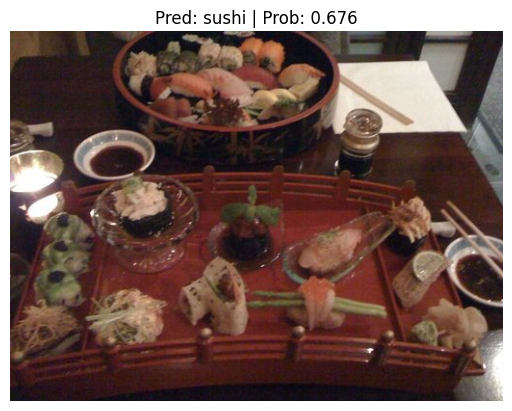

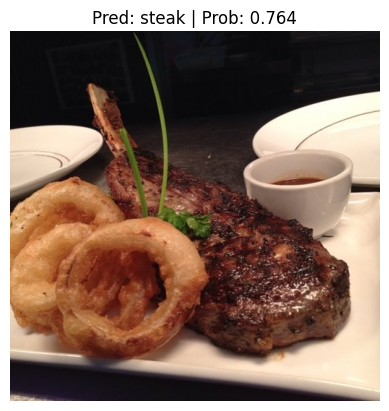

In [82]:
from going_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_images_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_images_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))


In [83]:
import requests
from pathlib import Path

custom_image_path = Path("data/04-pizza-dad.jpeg")

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\04-pizza-dad.jpeg already exists, skipping download.


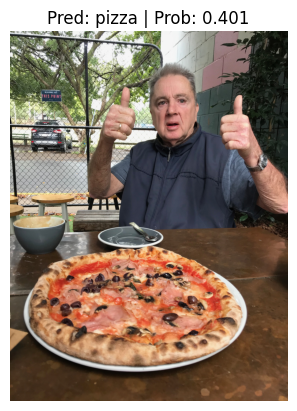

In [84]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)